### Project 1
#### Summer 2021
**Authors:** GOAT Team (Estaban Aramayo, Ethan Haley, Claire Meyer, and Tyler Frankenburg)

The [Cocktail DB](https://www.thecocktaildb.com/api.php) is a database of cocktails and ingredients. In this assignment, we describe how we could use the Cocktail DB's API to generate a network of cocktails and ingredients. We can use some example data to explore how we might be able to predict outcomes from this data using centrality metrics. 

##### Loading the Data

Without digging too deeply into the intricacies of the Cocktail DB API, we can leverage [this code](https://holypython.com/api-12-cocktail-database/) as a start for grabbing some example output from the API. This code leverages 2 libraries: `requests` to make an API request, and `json` to load the JSON output from the API. We can then iterate through each cocktail output to grab the relevant components. 

In this case, we're grabbing a sample of cocktail recipes that include Gin in the title. Were we to broaden this output, we could adjust the search query to pull all cocktail names (`strDrink`), the top 3 ingredients for each, and the drink categories (`strCategory`) for each cocktail.

In [3]:
import networkx as net
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

def cocktails(G):
    f = r"https://www.thecocktaildb.com/api/json/v1/1/search.php?s=gin"
    data = requests.get(f)
    tt = json.loads(data.text)

    for i in (tt["drinks"]):
        G.add_edge(i["strDrink"],i["strIngredient1"],category=i["strCategory"])
        G.add_edge(i["strDrink"],i["strIngredient2"],category=i["strCategory"])
        G.add_edge(i["strDrink"],i["strIngredient3"],category=i["strCategory"])
        #G[i["strDrink"]]["category"] = i["strCategory"] Does it make more sense to have node or edges categorized?
    return G

In [4]:
cocktail_graph=net.Graph()
cocktails(cocktail_graph)

We can see a quick visualization of this output below - we see the ingredient Gin as a center node, with other ingredients shared as well.

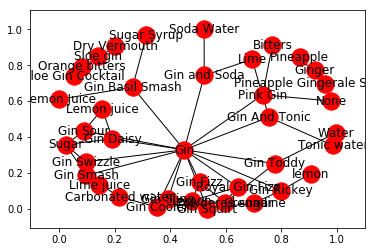

In [5]:
net.draw_networkx(cocktail_graph)

In [9]:
# can we color by category? gephi?

#### To Add 

From assignment: "In addition to identifying your data source, you should create a high level plan that describes how you would load the data for analysis, and describe a hypothetical outcome that could be predicted from comparing degree centrality across categorical groups. "

Notes: 
- commonality of different ingredients?
- how to stock your bar? 
- comparing across categorical group - "category" ingredients in "classic" categories might have higher centrality? more commonly used less niche?


Get all drinks, by first letter of name

In [5]:
baseUrl = "https://www.thecocktaildb.com/api/json/v1/1/"
letterEndpoint = "search.php?f="

def searchLetter(letter):
    data = requests.get(baseUrl + letterEndpoint + letter)
    return json.loads(data.text)

In [6]:
# Build a dataframe
name = []  # drink name
ids = []   # drink ID
cat = []   # drink category
pic = []   # thumbnail url
ingr = []  # ingredients

In [7]:
# helper function to parse ingredients
def ingreds(drinkDict):
    ing = []
    for i in range(1,16):  # API has 16 fields for ingredients of each drink, most of them empty/None
        s = "strIngredient" + str(i)
        if not d[s]:
            break
        ing.append(d[s])
    return ing

In [8]:
for l in 'abcdefghijklmnopqrstuvwxyz':
    
    drinks = searchLetter(l)['drinks']
    if not drinks: continue   #(some letters have no drinks)
    for d in drinks:
        name.append(d['strDrink'])
        ids.append(d['idDrink'])
        cat.append(d['strCategory'])
        pic.append(d['strDrinkThumb'])
        ingr.append(ingreds(d))

In [9]:
drinkDF = pd.DataFrame({'name': name,
                       'id': ids,
                       'category': cat,
                       'photoURL': pic,
                       'ingredients': ingr})
drinkDF

,name,id,category,photoURL,ingredients
0,A1,17222,Cocktail,https://www.thecocktaildb.com/images/media/dri...,"[Gin, Grand Marnier, Lemon Juice, Grenadine]"
1,ABC,13501,Shot,https://www.thecocktaildb.com/images/media/dri...,"[Amaretto, Baileys irish cream, Cognac]"
2,Ace,17225,Cocktail,https://www.thecocktaildb.com/images/media/dri...,"[Gin, Grenadine, Heavy cream, Milk, Egg White]"
3,Adam,17837,Ordinary Drink,https://www.thecocktaildb.com/images/media/dri...,"[Dark rum, Lemon juice, Grenadine]"
4,AT&T,13938,Ordinary Drink,https://www.thecocktaildb.com/images/media/dri...,"[Absolut Vodka, Gin, Tonic water]"
...,...,...,...,...,...
412,Zima Blaster,17027,Ordinary Drink,https://www.thecocktaildb.com/images/media/dri...,"[Zima, Chambord raspberry liqueur]"
413,Zizi Coin-coin,14594,Punch / Party Drink,https://www.thecocktaildb.com/images/media/dri...,"[Cointreau, Lemon juice, Ice, Lemon]"
414,Zippy's Revenge,14065,Cocktail,https://www.thecocktaildb.com/images/media/dri...,"[Amaretto, Rum, Kool-Aid]"
415,Zimadori Zinger,15801,Punch / Party Drink,https://www.thecocktaildb.com/images/media/dri...,"[Midori melon liqueur, Zima]"


Save/load the df so as not to have to make 26 API calls every time notebook opens

In [6]:
#drinkDF.to_csv('drinkDF.csv')
drinkDF = pd.read_csv('drinkDF.csv', index_col=0)

One more step needed on the load, since pandas converts lists to string literals on csv storage

In [7]:
import ast
drinkDF['ingredients'] = drinkDF.ingredients.apply(ast.literal_eval)

### Make a bipartite graph, with cocktails as one type and ingredients as the other.

In [70]:
from networkx.algorithms import bipartite

drinks = set(drinkDF.name.values)
ingreds = set(i for iList in drinkDF.ingredients.values for i in iList)

B = net.Graph()
B.add_nodes_from(drinks, bipartite='Cocktail')
B.add_nodes_from(ingreds, bipartite='Ingredient')

for d in range(len(drinkDF)):
    B.add_node(name[d], category=cat[d])
    for ing in ingr[d]:
        B.add_edge(name[d], ing)

Then the 2 bipartite projection graphs are these:

In [71]:
D = bipartite.weighted_projected_graph(B, drinks)
I = bipartite.weighted_projected_graph(B, ingreds)

In [72]:
D.nodes()

['Winter Rita',
 'Iced Coffee',
 'Frozen Mint Daiquiri',
 'Wine Cooler',
 'Midnight Manx',
 'Ruby Tuesday',
 'English Rose Cocktail',
 'Corpse Reviver',
 'Boston Sour',
 'Happy Skipper',
 'Radioactive Long Island Iced Tea',
 'Munich Mule',
 'Grand Blue',
 'Tequila Sunrise',
 'A. J.',
 'Darkwood Sling',
 'Grass Skirt',
 'Cafe Savoy',
 'Rail Splitter',
 'Limona Corona',
 'Sweet Sangria',
 'Freddy Kruger',
 'French Connection',
 'Rum Cooler',
 'Hot Creamy Bush',
 'ABC',
 'Tequila Surprise',
 'Autodafé',
 'Lemon Shot',
 'Hot Chocolate to Die for',
 'Vodka And Tonic',
 'Casino Royale',
 'Van Vleet',
 'Jackhammer',
 'Oreo Mudslide',
 'Vodka Martini',
 'Kamikaze',
 'Frozen Pineapple Daiquiri',
 'Ice Pick',
 'Thai Coffee',
 'Dirty Nipple',
 'Jamaican Coffee',
 'Pineapple Paloma',
 'Poppy Cocktail',
 "Mother's Milk",
 'GG',
 'Martini',
 'Vampiro',
 'Sweet Bananas',
 'Raspberry Julep',
 'Citrus Coke',
 'Mint Julep',
 'Pegu Club',
 'Just a Moonmint',
 'Mudslinger',
 'Veteran',
 'Espresso Rumtini'

### Calculate Centrality by Category

From the project doc: For each of the nodes in the dataset, calculate degree centrality and eigenvector centrality.
Compare your centrality measures across your categorical groups.

In [73]:
drinks_cocktails = drinkDF[(drinkDF['category']=="Cocktail")]
drinks_cocktails.head()

,name,id,category,photoURL,ingredients
0,A1,17222,Cocktail,https://www.thecocktaildb.com/images/media/dri...,"['Gin', 'Grand Marnier', 'Lemon Juice', 'Grena..."
2,Ace,17225,Cocktail,https://www.thecocktaildb.com/images/media/dri...,"['Gin', 'Grenadine', 'Heavy cream', 'Milk', 'E..."
12,Addison,17228,Cocktail,https://www.thecocktaildb.com/images/media/dri...,"['Gin', 'Vermouth']"
16,Aviation,17180,Cocktail,https://www.thecocktaildb.com/images/media/dri...,"['Gin', 'lemon juice', 'maraschino liqueur']"
21,Afterglow,12560,Cocktail,https://www.thecocktaildb.com/images/media/dri...,"['Grenadine', 'Orange juice', 'Pineapple juice']"


In [74]:
drinks_shots = drinkDF[(drinkDF['category']=="Shot")]
drinks_shots.head()

,name,id,category,photoURL,ingredients
1,ABC,13501,Shot,https://www.thecocktaildb.com/images/media/dri...,"['Amaretto', 'Baileys irish cream', 'Cognac']"
5,ACID,14610,Shot,https://www.thecocktaildb.com/images/media/dri...,"['151 proof rum', 'Wild Turkey']"
25,B-53,13332,Shot,https://www.thecocktaildb.com/images/media/dri...,"['Kahlua', 'Sambuca', 'Grand Marnier']"
26,B-52,15853,Shot,https://www.thecocktaildb.com/images/media/dri...,"['Baileys irish cream', 'Grand Marnier', 'Kahl..."
29,Big Red,13222,Shot,https://www.thecocktaildb.com/images/media/dri...,"['Irish cream', 'Goldschlager']"


In [77]:
drinks_c = set(drinks_cocktails.name.values)
ingreds_c = set(i for iList in drinks_cocktails.ingredients.values for i in iList)

dc_graph = net.Graph()

dc_graph.add_nodes_from(drinks_c, bipartite='Cocktail')
dc_graph.add_nodes_from(ingreds_c,bipartite='Ingredient')

for d in drinks_cocktails.index:
    dc_graph.add_node(name[d], category=cat[d])
    for ing in ingr[d]:
        dc_graph.add_edge(name[d], ing)

In [78]:
cocktail_degree = net.degree_centrality(dc_graph)
cocktail_degree = pd.DataFrame.from_dict(cocktail_degree, orient='index').reset_index()

In [80]:
drinks_s = set(drinks_shots.name.values)
ingreds_s = set(i for iList in drinks_shots.ingredients.values for i in iList)

ds_graph = net.Graph()

ds_graph.add_nodes_from(drinks_s, bipartite='Cocktail')
ds_graph.add_nodes_from(ingreds_s,bipartite='Ingredient')

for d in drinks_shots.index:
    ds_graph.add_node(name[d], category=cat[d])
    for ing in ingr[d]:
        ds_graph.add_edge(name[d], ing)

In [81]:
shots_degree = net.degree_centrality(ds_graph)
shots_degree = pd.DataFrame.from_dict(shots_degree, orient='index').reset_index()

In [82]:
shots_degree.head()

,index,0
0,Shot-gun,0.021277
1,Bob Marley,0.021277
2,Kool-Aid Slammer,0.014184
3,Damned if you do,0.014184
4,ABC,0.021277


In [70]:
# Eigenvector